# all partners PTE+AOP email to offer conversion prediction

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [ ]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [4]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [5]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [6]:
query="""
SELECT * FROM ml_prep.gauthier_all_partners_pte_aop_email_to_offer where  email_sent_date >= '2019-12-20 00:00:00' AND email_sent_date < '2020-01-11 00:00:00'  ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


pnr  partner_id point_of_sale language  loyalty_level  passenger_count  \
0  02B0KT          11            CZ       en              0                1   
1  037BM3          11            BY       en              0                3   
2  03F8UW          11            LB       en              0                3   

          email_sent_date segment_1_origination segment_1_destination  \
0 2020-01-01 06:06:45.620                   BOM                   AUH   
1 2020-01-09 07:08:56.447                   AUH                   LHR   
2 2020-01-04 07:10:31.447                   AUH                   LHR   

  segment_1_booked_fare_class  ... segment_4_booked_fare_class  \
0                           Y  ...                               
1                           Y  ...                               
2                           Y  ...                               

   segment_4_upgrade_cabin segment_4_flight_number segment_4_carrier_code  \
0                                              NaN                          
1                                              NaN                          
2                                              NaN                          

  segment_4_departure_local_date_time total_amount_itinerary_usd  \
0                                                            NaN   
1                                                            NaN   
2                                                            NaN   

  offer_item_count first_offer_datetime  has_offer         update_time  
0              NaN                  NaT      False 2020-07-21 15:14:36  
1              NaN                  NaT      False 2020-07-21 15:14:36  
2              NaN                  NaT      False 2020-07-21 15:14:36  

[3 rows x 40 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2608475 entries, 0 to 2608474
Data columns (total 40 columns):
pnr                                    object
partner_id                             int64
point_of_sale                          object
language                               object
loyalty_level                          int64
passenger_count                        int64
email_sent_date                        datetime64[ns]
segment_1_origination                  object
segment_1_destination                  object
segment_1_booked_fare_class            object
segment_1_upgrade_cabin                object
segment_1_flight_number                float64
segment_1_carrier_code                 object
segment_1_departure_local_date_time    object
segment_2_origination                  object
segment_2_destination                  object
segment_2_booked_fare_class            object
segment_2_upgrade_cabin                object
segment_2_flight_number                float64
segmen

# Feature Engineering

In [8]:
# compute some time-related features
# this takes some time

# email sent time
df['email_sent_day_of_week']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.dayofweek)
df['email_sent_hour']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.hour)
df['email_sent_month']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.month)
df['email_sent_year']= pd.to_datetime(df['email_sent_date']).apply(lambda x: x.year)
df["email_sent_days_before_departure"] =(pd.to_datetime(df["segment_1_departure_local_date_time"])-pd.to_datetime(df["email_sent_date"]).dt.tz_localize(None)).apply(lambda x: x.days)


In [9]:
# segment 1 
df['segment_1_departure_hour'] = pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_1_departure_day_of_week']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_1_departure_month']= pd.to_datetime(df['segment_1_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_1_origin_destination'] = df['segment_1_origination']+ df['segment_1_destination']

# segment 2
df['segment_2_departure_hour'] = pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_2_departure_day_of_week']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_2_departure_month']= pd.to_datetime(df['segment_2_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_2_origin_destination'] = df['segment_2_origination']+ df['segment_2_destination']

# segment 3
df['segment_3_departure_hour'] = pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_3_departure_day_of_week']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_3_departure_month']= pd.to_datetime(df['segment_3_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_3_origin_destination'] = df['segment_3_origination']+ df['segment_3_destination']

# segment 4
df['segment_4_departure_hour'] = pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.hour).fillna(0).astype(int)
df['segment_4_departure_day_of_week']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.dayofweek).fillna(0).astype(int)
df['segment_4_departure_month']= pd.to_datetime(df['segment_4_departure_local_date_time']).apply(lambda x: x.month).fillna(0).astype(int)
df['segment_4_origin_destination'] = df['segment_4_origination']+ df['segment_4_destination']

df['passenger_count'] = df['passenger_count'].fillna(0).astype(int)


In [10]:
df[:3]

pnr  partner_id point_of_sale language  loyalty_level  passenger_count  \
0  02B0KT          11            CZ       en              0                1   
1  037BM3          11            BY       en              0                3   
2  03F8UW          11            LB       en              0                3   

          email_sent_date segment_1_origination segment_1_destination  \
0 2020-01-01 06:06:45.620                   BOM                   AUH   
1 2020-01-09 07:08:56.447                   AUH                   LHR   
2 2020-01-04 07:10:31.447                   AUH                   LHR   

  segment_1_booked_fare_class  ... segment_2_departure_month  \
0                           Y  ...                         0   
1                           Y  ...                         0   
2                           Y  ...                         0   

   segment_2_origin_destination segment_3_departure_hour  \
0                                                      0   
1                                                      0   
2                                                      0   

  segment_3_departure_day_of_week segment_3_departure_month  \
0                               0                         0   
1                               0                         0   
2                               0                         0   

  segment_3_origin_destination segment_4_departure_hour  \
0                                                     0   
1                                                     0   
2                                                     0   

  segment_4_departure_day_of_week  segment_4_departure_month  \
0                               0                          0   
1                               0                          0   
2                               0                          0   

  segment_4_origin_destination  
0                               
1                               
2                               

[3 rows x 61 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2608475 entries, 0 to 2608474
Data columns (total 61 columns):
pnr                                    object
partner_id                             int64
point_of_sale                          object
language                               object
loyalty_level                          int64
passenger_count                        int64
email_sent_date                        datetime64[ns]
segment_1_origination                  object
segment_1_destination                  object
segment_1_booked_fare_class            object
segment_1_upgrade_cabin                object
segment_1_flight_number                float64
segment_1_carrier_code                 object
segment_1_departure_local_date_time    object
segment_2_origination                  object
segment_2_destination                  object
segment_2_booked_fare_class            object
segment_2_upgrade_cabin                object
segment_2_flight_number                float64
segmen

# Feature Encoding

In [12]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [13]:
# label-encode categories
# there is no channel source since it's always PTE.
columns = ['language','point_of_sale'] + \
['segment_1_origination','segment_1_destination','segment_1_origin_destination','segment_1_booked_fare_class','segment_1_upgrade_cabin']+ \
['segment_2_origination','segment_2_destination','segment_2_origin_destination','segment_2_booked_fare_class','segment_2_upgrade_cabin'] + \
['segment_3_origination','segment_3_destination','segment_3_origin_destination','segment_3_booked_fare_class','segment_3_upgrade_cabin'] + \
['segment_4_origination','segment_4_destination','segment_4_origin_destination','segment_4_booked_fare_class','segment_4_upgrade_cabin'] 

df= label_encode_categorical(df,columns)


label encoding language ...
label encoding point_of_sale ...
label encoding segment_1_origination ...
label encoding segment_1_destination ...
label encoding segment_1_origin_destination ...
label encoding segment_1_booked_fare_class ...
label encoding segment_1_upgrade_cabin ...
label encoding segment_2_origination ...
label encoding segment_2_destination ...
label encoding segment_2_origin_destination ...
label encoding segment_2_booked_fare_class ...
label encoding segment_2_upgrade_cabin ...
label encoding segment_3_origination ...
label encoding segment_3_destination ...
label encoding segment_3_origin_destination ...
label encoding segment_3_booked_fare_class ...
label encoding segment_3_upgrade_cabin ...
label encoding segment_4_origination ...
label encoding segment_4_destination ...
label encoding segment_4_origin_destination ...
label encoding segment_4_booked_fare_class ...
label encoding segment_4_upgrade_cabin ...


In [14]:
columns_for_training= [    
                        # segment 1
                        'segment_1_origination_encoded',
                        'segment_1_destination_encoded',
                        'segment_1_origin_destination_encoded',
                        'segment_1_booked_fare_class_encoded',
                        'segment_1_upgrade_cabin_encoded',
    
                         # segment 2
                        'segment_2_origination_encoded',
                        'segment_2_destination_encoded',
                        'segment_2_origin_destination_encoded',
                        'segment_2_booked_fare_class_encoded',
                        'segment_2_upgrade_cabin_encoded',

                         # segment 3
                        'segment_3_origination_encoded',
                        'segment_3_destination_encoded',
                        'segment_3_origin_destination_encoded',
                        'segment_3_booked_fare_class_encoded',
                        'segment_3_upgrade_cabin_encoded',

                         # segment 4
                        'segment_4_origination_encoded',
                        'segment_4_destination_encoded',
                        'segment_4_origin_destination_encoded',
                        'segment_4_booked_fare_class_encoded',
                        'segment_4_upgrade_cabin_encoded',
    
                        # email
                        'email_sent_day_of_week',
                        'email_sent_hour',
                        'email_sent_month',
                        'email_sent_year',
                        'email_sent_days_before_departure',
    
                        # 
                        'partner_id',
    
                       # the rest
                       'language_encoded',
                       'passenger_count',
                       'point_of_sale_encoded',

                       # target
                        'has_offer',
                      ]

df_train = df[columns_for_training]

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2608475 entries, 0 to 2608474
Data columns (total 30 columns):
segment_1_origination_encoded           int64
segment_1_destination_encoded           int64
segment_1_origin_destination_encoded    int64
segment_1_booked_fare_class_encoded     int64
segment_1_upgrade_cabin_encoded         int64
segment_2_origination_encoded           int64
segment_2_destination_encoded           int64
segment_2_origin_destination_encoded    int64
segment_2_booked_fare_class_encoded     int64
segment_2_upgrade_cabin_encoded         int64
segment_3_origination_encoded           int64
segment_3_destination_encoded           int64
segment_3_origin_destination_encoded    int64
segment_3_booked_fare_class_encoded     int64
segment_3_upgrade_cabin_encoded         int64
segment_4_origination_encoded           int64
segment_4_destination_encoded           int64
segment_4_origin_destination_encoded    int64
segment_4_booked_fare_class_encoded     int64
segment_4_upg

In [16]:
df_train.head(4)

segment_1_origination_encoded  segment_1_destination_encoded  \
0                             91                             42   
1                             44                            400   
2                             44                            400   
3                             91                             42   

   segment_1_origin_destination_encoded  segment_1_booked_fare_class_encoded  \
0                                   944                                  247   
1                                   529                                  247   
2                                   529                                  247   
3                                   944                                  247   

   segment_1_upgrade_cabin_encoded  segment_2_origination_encoded  \
0                               13                              0   
1                                7                              0   
2                                5                              0   
3                               13                              0   

   segment_2_destination_encoded  segment_2_origin_destination_encoded  \
0                              0                                     0   
1                              0                                     0   
2                              0                                     0   
3                              0                                     0   

   segment_2_booked_fare_class_encoded  segment_2_upgrade_cabin_encoded  ...  \
0                                    0                                0  ...   
1                                    0                                0  ...   
2                                    0                                0  ...   
3                                    0                                0  ...   

   email_sent_day_of_week  email_sent_hour  email_sent_month  email_sent_year  \
0                       2                6                 1             2020   
1                       3                7                 1             2020   
2                       5                7                 1             2020   
3                       4                6                 1             2020   

   email_sent_days_before_departure  partner_id  language_encoded  \
0                                 4          11                19   
1                                 5          11                19   
2                                 5          11                19   
3                                 5          11                19   

   passenger_count  point_of_sale_encoded  has_offer  
0                1                     39      False  
1                3                     24      False  
2                3                     88      False  
3                1                    136      False  

[4 rows x 30 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f689a5cf668>]],
      dtype=object)

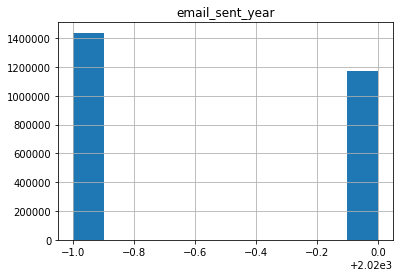

In [17]:
# we could use month to split train/test data
pd.DataFrame.hist(df_train,column='email_sent_year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f689a12e390>]],
      dtype=object)

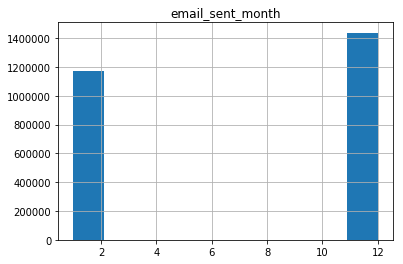

In [18]:
# we could use month to split train/test data
pd.DataFrame.hist(df_train,column='email_sent_month')

# Model Training & Evaluation

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, title=None):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title is not None:
        plt.title(title)
    plt.show()
        

In [20]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False, by_partner=False, sim=False):
    # X-validation
    import warnings
    from sklearn.exceptions import UndefinedMetricWarning
    warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("has_offer", axis=1)
    y = df_to_train["has_offer"]

    
    if split_on_time:
        X_train = X[X["email_sent_year"] == 2019 ].drop("email_sent_year", axis=1)
        y_train = y[X["email_sent_year"] == 2019]
        X_test = X[X["email_sent_year"] == 2020].drop("email_sent_year", axis=1)
        y_test = y[X["email_sent_year"] == 2020]
        print('split on time')
    else:
        X = X.drop("email_sent_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    for feature,importance in zip(features[indices],importances[indices]):
        print(feature+','+str(importance))
    plt.show()

    if sim:
        print('Running simulation on test set')
        total_email_sent = len(y_test)
        print(total_email_sent, 'email sent')
        print(len(y_test[y_test==1]), 'actual number of offers')
        ratio = len(y_test[y_test==1]) / total_email_sent
        print('conversion ratio',ratio)
        threshold=0.5
        predicted_positive = len(y_test_proba[y_test_proba > threshold])
        print('predicted_positive',predicted_positive,'with threshold',threshold)
        total_current_proba = y_test_proba.sum()
        total_max_proba = 0
        best_sent_hours_for_all=[]
        original_sent_hours_for_all=[]

        all_dfs=[]
        for email_sent_hour in range(0,24):
            #min_index = email_sent_hour * total_email_sent
            #max_index = (email_sent_hour +1) * total_email_sent
            #print('email_sent_hour',email_sent_hour,'min_index',min_index,'max_index',max_index)
            #X_test_repeated.iloc[min_index:max_index]['email_sent_date'] = email_sent_hour
            df_for_hour = X_test.copy()
            df_for_hour['email_sent_hour'] = email_sent_hour
            all_dfs.append(df_for_hour)
            
        X_test_repeated=pd.concat(all_dfs,ignore_index=True)
        print('size of new test set',X_test_repeated.shape[0])
        proba_repeated = random_forest.predict_proba(X_test_repeated)[:,1]
        
        mod = int(X_test.shape[0] / 20)
        
        best_proba_by_partner = {}
        
        for index in range(total_email_sent):
            indexes = []
            for email_sent_hour in range(0,24):
                indexes.append( email_sent_hour * total_email_sent + index)
            
            probas_for_index = proba_repeated[indexes]
            original_email_sent_hour = X_test.iloc[index]['email_sent_hour']
            original_proba = y_test_proba[index]
            
            max_proba = max(probas_for_index)
            
            best_email_sent_hour = np.argmax(probas_for_index)
            
            if max_proba==original_proba:
                best_email_sent_hour=original_email_sent_hour
            
            if index % mod == 0 :
                print('Row',index,'raw_email_sent_hour',original_email_sent_hour,
                         'raw_proba',original_proba,'best_email_sent_hour',best_email_sent_hour,'best_proba',max_proba)
                #print(probas_for_index)
            
            best_sent_hours_for_all.append(best_email_sent_hour)
            original_sent_hours_for_all.append(original_email_sent_hour)
            
            new_sum_for_partner = best_proba_by_partner.get(X_test.iloc[index]['partner_id'], 0) + max_proba
            best_proba_by_partner[X_test.iloc[index]['partner_id']] = new_sum_for_partner
            
            total_max_proba = total_max_proba + max_proba
            
        print('total_current_proba',total_current_proba)
        print('total_max_proba',total_max_proba)

        # if our model was perfect, it would increase ...
        
        plt.hist(original_sent_hours_for_all)
        plt.title('Original sent hour')
        plt.show()

        
        plt.hist(best_sent_hours_for_all)
        plt.title('Optimized sent hour')
        plt.show()
        
        partner_ids = sorted(X_test['partner_id'].unique())
        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            original_proba_for_partner = y_test_proba[indexes_for_partner].sum()
            print('partner_id',partner_id,'original_proba_for_partner',original_proba_for_partner,'optimized proba',best_proba_by_partner[partner_id])
        
        
        
    if by_partner:
        print('Analysis by partner...')
        partner_ids = sorted(X_test['partner_id'].unique())
        print(partner_ids)
        rocs = []
        f1s = []

        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            y_test_for_partner = y_test[indexes_for_partner] 
            y_test_proba_for_partner = y_test_proba[indexes_for_partner]
            y_test_predict_for_partner = y_test_predict[indexes_for_partner]
            
            y_for_partner = y[X['partner_id'] == partner_id]
            
            fpr, tpr, _ = metrics.roc_curve(y_test_for_partner, y_test_proba_for_partner)
            auc = metrics.auc(fpr, tpr)
            print('#### Partner',str(partner_id)+' ('+str(len(y_test_proba_for_partner)),'rows in test set) #### ')
            print('roc auc',auc)
            rocs.append(auc)
            try:
                precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test_for_partner,y_test_predict_for_partner)
                print('precision', precision[1])
                print('recall', recall[1])
                print('f1', f1[1])
                print('support', support[1])
                the_f1 = f1[1]
                plt.figure(figsize=(10,7))
                plt.title('Precision-Recall for partner '+ str(partner_id))
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_for_partner, y_test_proba_for_partner)
                # proportion of positive examples
                no_skill = len(y_for_partner[y_for_partner==1]) / len(y_for_partner)
                plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
                plt.plot(recalls, precisions, marker='.')    
                plt.show()
                cm = metrics.confusion_matrix(y_test_for_partner, y_test_predict_for_partner)
                print_confusion_matrix(cm, ['no bid','bid'], title='partner id ' + str(partner_id))
            except:
                the_f1 = 0
            f1s.append(the_f1)
        plt.figure(figsize=(16,9))
        plt.title('ROC by partner')
        plt.bar([str(i) for i in partner_ids], rocs, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
        
        plt.figure(figsize=(16,9))
        plt.title('F1 by partner')
        plt.bar([str(i) for i in partner_ids], f1s, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)



split on time
training on 275401 rows...
training is done!
precision 0.2882882882882883
recall 0.030818619582664526
f1 0.05568445475638051
support 3115


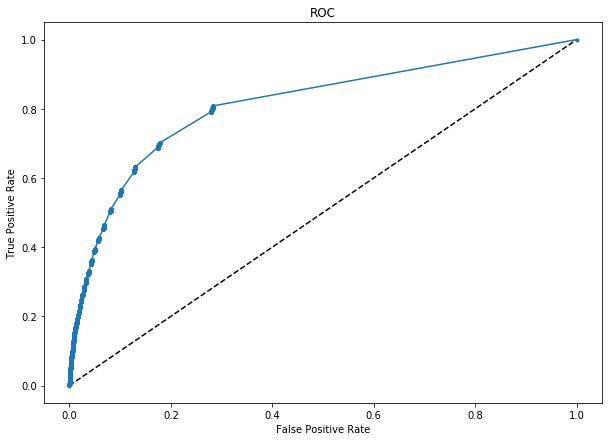

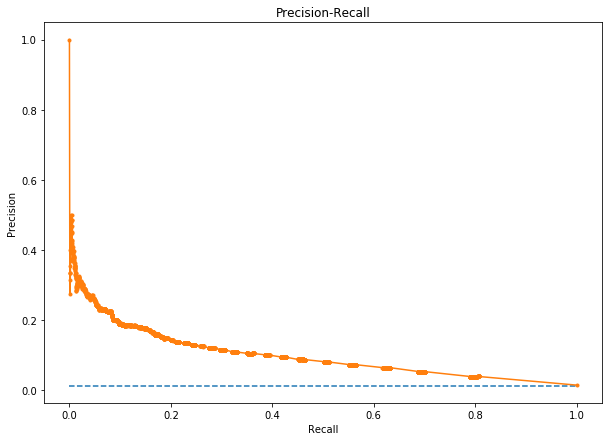

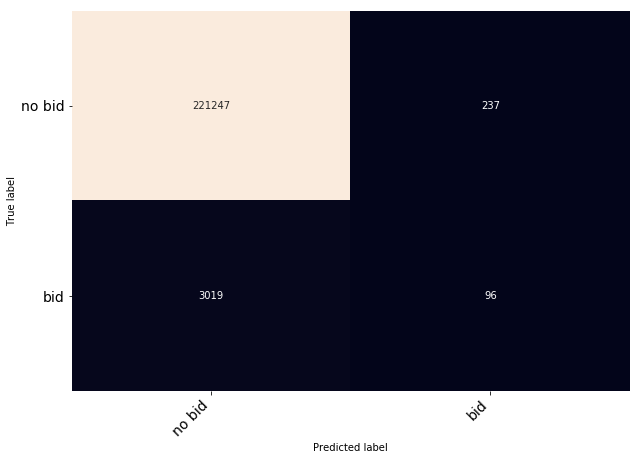

roc auc 0.8125071540627467
segment_1_booked_fare_class_encoded,0.17509512361653728
email_sent_days_before_departure,0.13367462556739249
email_sent_day_of_week,0.10170066687565023
segment_1_origin_destination_encoded,0.07278699454552295
passenger_count,0.06183955033111375
email_sent_hour,0.058759864781464714
segment_1_destination_encoded,0.056295150551005674
segment_1_origination_encoded,0.04507625171683752
segment_2_booked_fare_class_encoded,0.04480847321890547
segment_1_upgrade_cabin_encoded,0.03748086451701176
partner_id,0.036581872398903675
point_of_sale_encoded,0.03411937638059254
segment_2_origin_destination_encoded,0.03211569170883281
segment_2_destination_encoded,0.021405107468259785
language_encoded,0.020735679556726342
segment_2_origination_encoded,0.01988421511551137
segment_3_origin_destination_encoded,0.007314657276411937
segment_2_upgrade_cabin_encoded,0.006576768222478596
segment_3_booked_fare_class_encoded,0.006151966644174148
segment_3_origination_encoded,0.005839014988

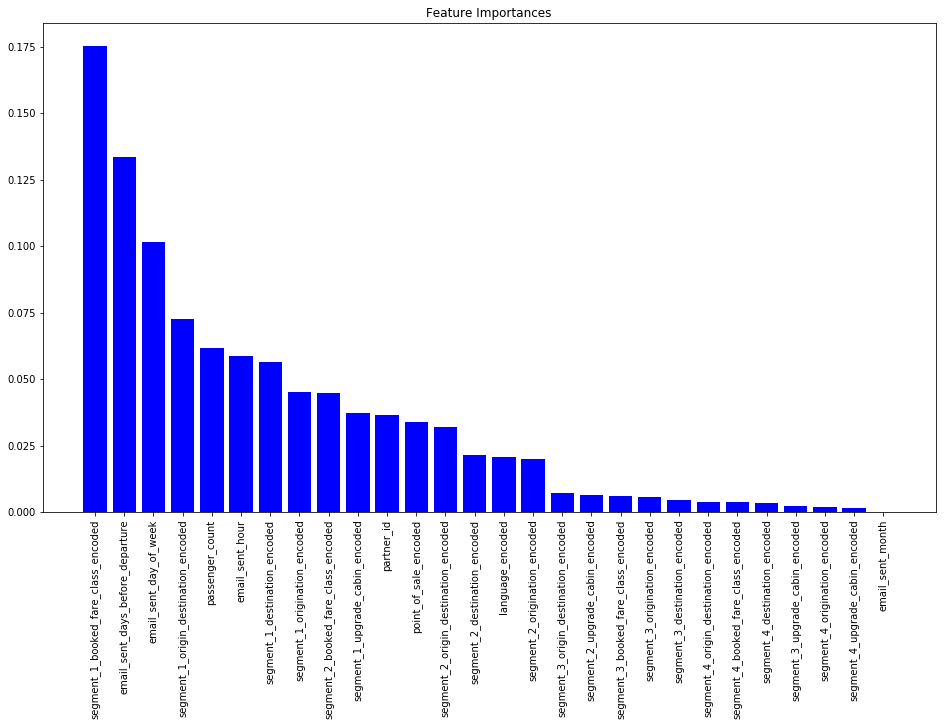

Running simulation on test set
224599 email sent
3115 actual number of offers
conversion ratio 0.013869162373830693
predicted_positive 333 with threshold 0.5
size of new test set 5390376
Row 0 raw_email_sent_hour 6 raw_proba 0.0 best_email_sent_hour 23 best_proba 0.05
Row 11229 raw_email_sent_hour 16 raw_proba 0.03 best_email_sent_hour 20 best_proba 0.05
Row 22458 raw_email_sent_hour 1 raw_proba 0.12 best_email_sent_hour 0 best_proba 0.16
Row 33687 raw_email_sent_hour 16 raw_proba 0.0 best_email_sent_hour 1 best_proba 0.04
Row 44916 raw_email_sent_hour 3 raw_proba 0.0 best_email_sent_hour 3 best_proba 0.0
Row 56145 raw_email_sent_hour 14 raw_proba 0.02 best_email_sent_hour 20 best_proba 0.06
Row 67374 raw_email_sent_hour 8 raw_proba 0.0 best_email_sent_hour 2 best_proba 0.05
Row 78603 raw_email_sent_hour 18 raw_proba 0.0 best_email_sent_hour 0 best_proba 0.02
Row 89832 raw_email_sent_hour 14 raw_proba 0.0740952380952381 best_email_sent_hour 20 best_proba 0.19742857142857143
Row 101061 

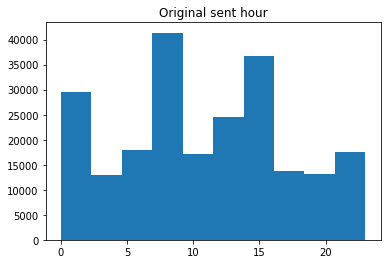

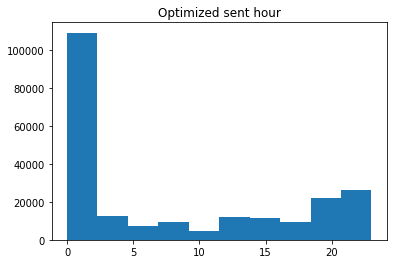

found  56 partners in the test set
partner_id 1 original_proba_for_partner 29.314583333333335 optimized proba 95.59341666666653
partner_id 4 original_proba_for_partner 7.884404761904762 optimized proba 62.80783333333401
partner_id 8 original_proba_for_partner 32.355333333333334 optimized proba 90.18383333333361
partner_id 9 original_proba_for_partner 71.14 optimized proba 204.67133333333538
partner_id 11 original_proba_for_partner 124.85388095238095 optimized proba 517.8348928571248
partner_id 12 original_proba_for_partner 23.491 optimized proba 100.36266666666707
partner_id 13 original_proba_for_partner 93.56375793650793 optimized proba 468.2480357142856
partner_id 18 original_proba_for_partner 2.4516666666666667 optimized proba 29.729999999999993
partner_id 20 original_proba_for_partner 0.6195833333333334 optimized proba 1.4754166666666668
partner_id 23 original_proba_for_partner 1.4483333333333335 optimized proba 9.979499999999963
partner_id 24 original_proba_for_partner 9.475000000

In [21]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=500_000, split_on_time=True, sim=True)

In [ ]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=None, split_on_time=True, by_partner=True)

split on time
training on 1437315 rows...
training is done!
y_test_proba [0.  0.  0.1 ... 0.  0.  0. ]
y_test_predict [False False False ... False False False]
precision 0.2857142857142857
recall 0.04456521739130435
f1 0.077103902209685
support 16560
roc auc 0.8223729472992299
segment_1_booked_fare_class_encoded,0.17058545978793657
email_sent_days_before_departure,0.1526331943537295
email_sent_day_of_week,0.11472475660075798
passenger_count,0.06527563841038972
segment_1_origin_destination_encoded,0.0624922416727997
email_sent_hour,0.06001097800491605
segment_2_booked_fare_class_encoded,0.05243852951943067
segment_1_destination_encoded,0.04618235213773136
segment_1_origination_encoded,0.03827952810913993
partner_id,0.0358154351973817
point_of_sale_encoded,0.03323887009894386
segment_2_origin_destination_encoded,0.030833355997243315
segment_1_upgrade_cabin_encoded,0.028301233160849645
segment_2_destination_encoded,0.021306038785735285
language_encoded,0.020237618780765333
segment_2_origi

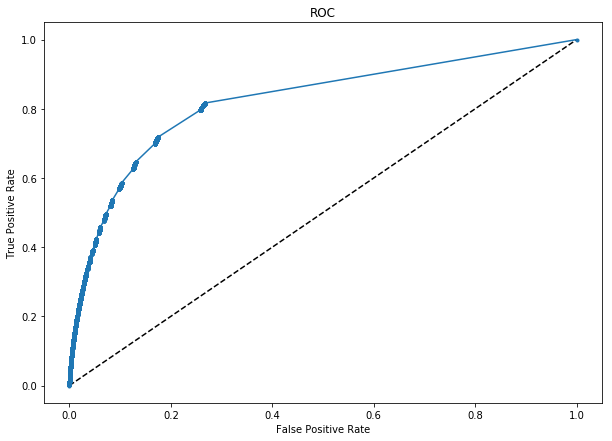

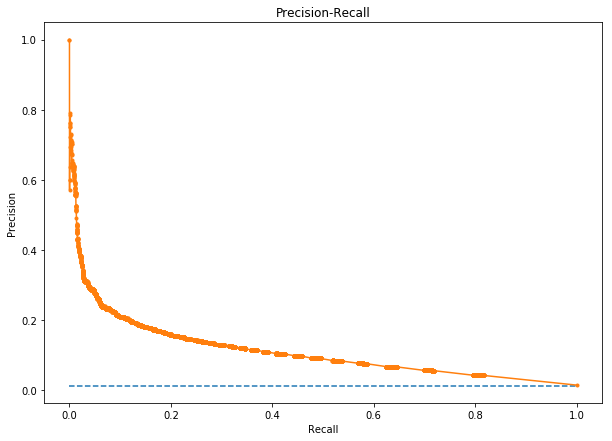

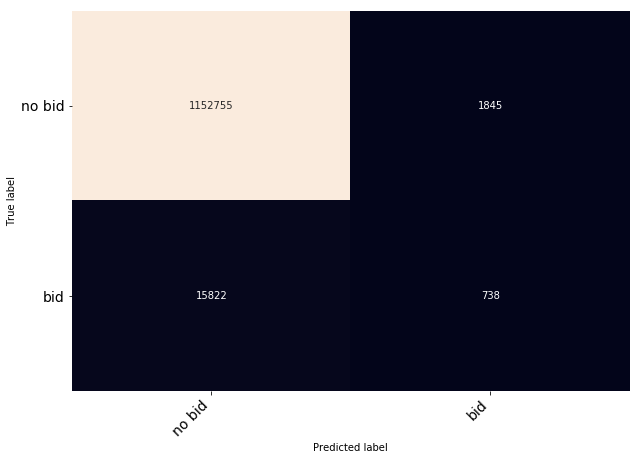

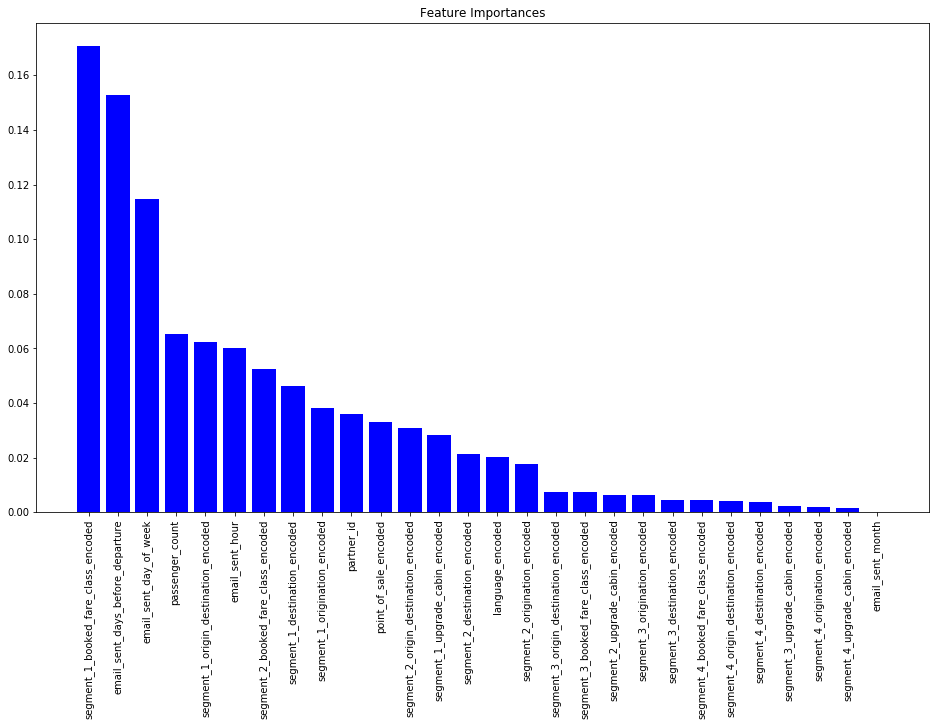

In [19]:
train_and_evaluate(df_train,plot_learning_curves=False,limit=None, split_on_time=True)